In [1]:
import gc
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
from sklearn.utils import resample
from collections import Counter
import math
from sklearn.model_selection import train_test_split
import helper
import dataset
import torch
import torch.nn as nn
from resnet1d.net1d import Net1D

In [2]:
data_files = [name for name in os.listdir('./data')]

dfs = []

for i in range(len(data_files)):
    fname = './data/' + data_files[i]
    df = pd.read_csv(fname)
    # df.columns = [x.strip().lstrip() for x in df.columns]

    dfs.append(df)

df = pd.concat(dfs, axis=0, ignore_index=True)

df.shape

(2830743, 79)

In [3]:
# Remove spaces in the front and the end of the column names for better human reading
df.columns = [x.lstrip().strip().replace('�', '-') for x in df.columns]
df.shape

(2830743, 79)

In [4]:
# replace inf values to nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(2827876, 79)

In [5]:
df_train, df_val = train_test_split(df, stratify=df['Label'], test_size=0.2, random_state=42)

In [6]:
X = df_val.drop(['Label'], axis=1)
y = df_val['Label']

In [7]:
with open('./dist/labelencoder-resnet.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('./dist/preprocessor-resnet.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

In [8]:
preprocessor

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('normalize', MinMaxScaler()), ('PCA', PCA(n_components=20))])

In [9]:
label_encoder

LabelEncoder()

In [10]:
X = preprocessor.transform(X)
y = label_encoder.transform(y)

In [11]:
X.shape

(565576, 20)

In [12]:
Counter(y)

Counter({0: 454265,
         4: 46025,
         10: 31761,
         2: 25605,
         3: 2059,
         7: 1587,
         11: 1180,
         6: 1159,
         5: 1100,
         1: 391,
         12: 301,
         14: 130,
         9: 7,
         13: 4,
         8: 2})

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

with open('./dist/resnet/extractor1d-170.pkl', 'rb') as f:
    extractor = pickle.load(f)

extractor.to(device)
extractor.eval()

Extractor(
  (resnet): Net1D(
    (first_conv): MyConv1dPadSame(
      (conv): Conv1d(1, 20, kernel_size=(16,), stride=(2,))
    )
    (first_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (first_activation): Swish()
    (stage_list): ModuleList(
      (0): BasicStage(
        (block_list): ModuleList(
          (0): BasicBlock(
            (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation1): Swish()
            (do1): Dropout(p=0.5, inplace=False)
            (conv1): MyConv1dPadSame(
              (conv): Conv1d(20, 64, kernel_size=(1,), stride=(1,))
            )
            (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation2): Swish()
            (do2): Dropout(p=0.5, inplace=False)
            (conv2): MyConv1dPadSame(
              (conv): Conv1d(64, 64, kernel_size=(16,), stride=(2,), groups=4)
            )
          

In [14]:
X = np.expand_dims(X, axis=2).transpose((0, 2, 1))

dataset = dataset.NumpyDataset(X, y)
len(dataset)

565576

In [15]:
from torch.utils.data import DataLoader

embeddings = []
labels = []
batch_size = 1024
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)

for X, y in dataloader:
    X = X.to(device)
    X_embedding = extractor(X)
    embeddings.append(X_embedding.cpu().detach().numpy())

    labels.append(y)

In [16]:
X_embedding = np.concatenate(embeddings, axis=0)
y = np.concatenate(labels, axis=0)
print(X_embedding.shape)
print(y.shape)

(565576, 34)
(565576,)


In [17]:
from sklearn.neural_network import  MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

knn_list = [5, 10]

estimators = [MLPClassifier(max_iter=1500), DecisionTreeClassifier(), GaussianNB(), LogisticRegression(max_iter=500), RandomForestClassifier()] \
    + [KNeighborsClassifier(n_neighbors=k) for k in knn_list]

estimators

[MLPClassifier(max_iter=1500),
 DecisionTreeClassifier(),
 GaussianNB(),
 LogisticRegression(max_iter=500),
 RandomForestClassifier(),
 KNeighborsClassifier(),
 KNeighborsClassifier(n_neighbors=10)]

In [18]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
}

performance = {}

for model in estimators:
    results = cross_validate(model, X_embedding, y, scoring=scoring)
    performance[model.__repr__()] = results

    print(f"finished evaluation on {model.__repr__()}")

/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on MLPClassifier(max_iter=1500)


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on DecisionTreeClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on GaussianNB()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

finished evaluation on LogisticRegression(max_iter=500)
finished evaluation on RandomForestClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on KNeighborsClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on KNeighborsClassifier(n_neighbors=10)


In [19]:
resnet_performance = performance

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=1500)

ypred = cross_val_predict(model, X_embedding, y, cv=5)
cf_matrix_resnet_resnet = confusion_matrix(y, ypred)

In [21]:
# load mlp extractor
with open('./dist/mlp/extractor1d-final.pkl', 'rb') as f:
    extractor = pickle.load(f)

extractor.to(device)
extractor.eval()

ExtractorMLP(
  (conv1d): MyConv1dPadSame(
    (conv): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
  )
  (linear_in): Linear(in_features=20, out_features=65, bias=True)
  (backbone): Sequential(
    (linear-0): Linear(in_features=65, out_features=65, bias=True)
    (act-0): ReLU()
  )
  (linear_out): Linear(in_features=65, out_features=39, bias=True)
)

## Eval of MLP feature extractor

In [22]:
embeddings = []
labels = []
batch_size = 1024
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)

for X, y in dataloader:
    X = X.to(device)
    X_embedding = extractor(X)
    embeddings.append(X_embedding.cpu().detach().numpy())

    labels.append(y)

In [23]:
X_embedding = np.concatenate(embeddings, axis=0)
y = np.concatenate(labels, axis=0)
print(X_embedding.shape)
print(y.shape)

(565576, 39)
(565576,)


In [23]:
performance = {}

for model in estimators:
    results = cross_validate(model, X_embedding, y, scoring=scoring)
    performance[model.__repr__()] = results

    print(f"finished evaluation on {model.__repr__()}")

/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on MLPClassifier(max_iter=1500)


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on DecisionTreeClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on GaussianNB()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

finished evaluation on LogisticRegression(max_iter=500)
finished evaluation on RandomForestClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on KNeighborsClassifier()


/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


finished evaluation on KNeighborsClassifier(n_neighbors=10)


In [24]:
mlp_performance = performance

In [25]:
metric_keys = [f'test_{x}' for x in scoring.keys()]

mlp_performance['DecisionTreeClassifier()']

for model in estimators: 
    model_name = model.__repr__()
    fig, axes = plt.subplots(2, 3)
    for i in range(len(metric_keys)):
        key = metric_keys[i]
        row = key // 3
        col = key % 3 

        axes[row, col].plot()


{'fit_time': array([57.91320348, 59.32633638, 59.03970337, 57.68608141, 57.33490396]),
 'score_time': array([0.14851999, 0.147825  , 0.14329743, 0.13228631, 0.14532042]),
 'test_f1_weighted': array([0.9853872 , 0.98473469, 0.98481031, 0.98529915, 0.98459861]),
 'test_precision_weighted': array([0.98539792, 0.98477917, 0.98484787, 0.98532527, 0.98465799]),
 'test_recall_weighted': array([0.98538668, 0.98469699, 0.9847854 , 0.98528047, 0.98455554]),
 'test_accuracy': array([0.98538668, 0.98469699, 0.9847854 , 0.98528047, 0.98455554]),
 'test_f1_macro': array([0.68611908, 0.68175333, 0.76262984, 0.68064059, 0.72061268]),
 'test_precision_macro': array([0.68786662, 0.67849618, 0.74610466, 0.67944644, 0.71758514]),
 'test_recall_macro': array([0.68482565, 0.68547334, 0.80327528, 0.68208705, 0.72379792])}

In [37]:
metric_keys = [f'test_{x}' for x in scoring.keys()]

for model in estimators:
    model_name = model.__repr__()
    print('='*10 + model_name + '='*10)
    print(f'{"":30} {"mlp"}\t\t {"resnet"}')
    for metric in metric_keys:
        print(f'{metric:30} {np.average(mlp_performance[model_name][metric]):.6f} \t {np.average(resnet_performance[model_name][metric]):.6f}') 

==========MLPClassifier(max_iter=1500)==========
                               mlp		 resnet
test_f1_weighted               0.970910 	 0.978402
test_precision_weighted        0.971440 	 0.978790
test_recall_weighted           0.971284 	 0.978929
test_accuracy                  0.971284 	 0.978929
test_f1_macro                  0.641212 	 0.657772
test_precision_macro           0.709399 	 0.754100
test_recall_macro              0.632646 	 0.631850
==========DecisionTreeClassifier()==========
                               mlp		 resnet
test_f1_weighted               0.984966 	 0.987107
test_precision_weighted        0.985002 	 0.987138
test_recall_weighted           0.984941 	 0.987086
test_accuracy                  0.984941 	 0.987086
test_f1_macro                  0.706351 	 0.719794
test_precision_macro           0.701900 	 0.718925
test_recall_macro              0.715892 	 0.721341
==========GaussianNB()==========
                               mlp		 resnet
test_f1_weighted           

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=1500)

ypred = cross_val_predict(model, X_embedding, y, cv=5)
cf_matrix_mlp_mlp = confusion_matrix(y, ypred)

/home/chan/miniconda3/envs/csi5388/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


<Axes: >

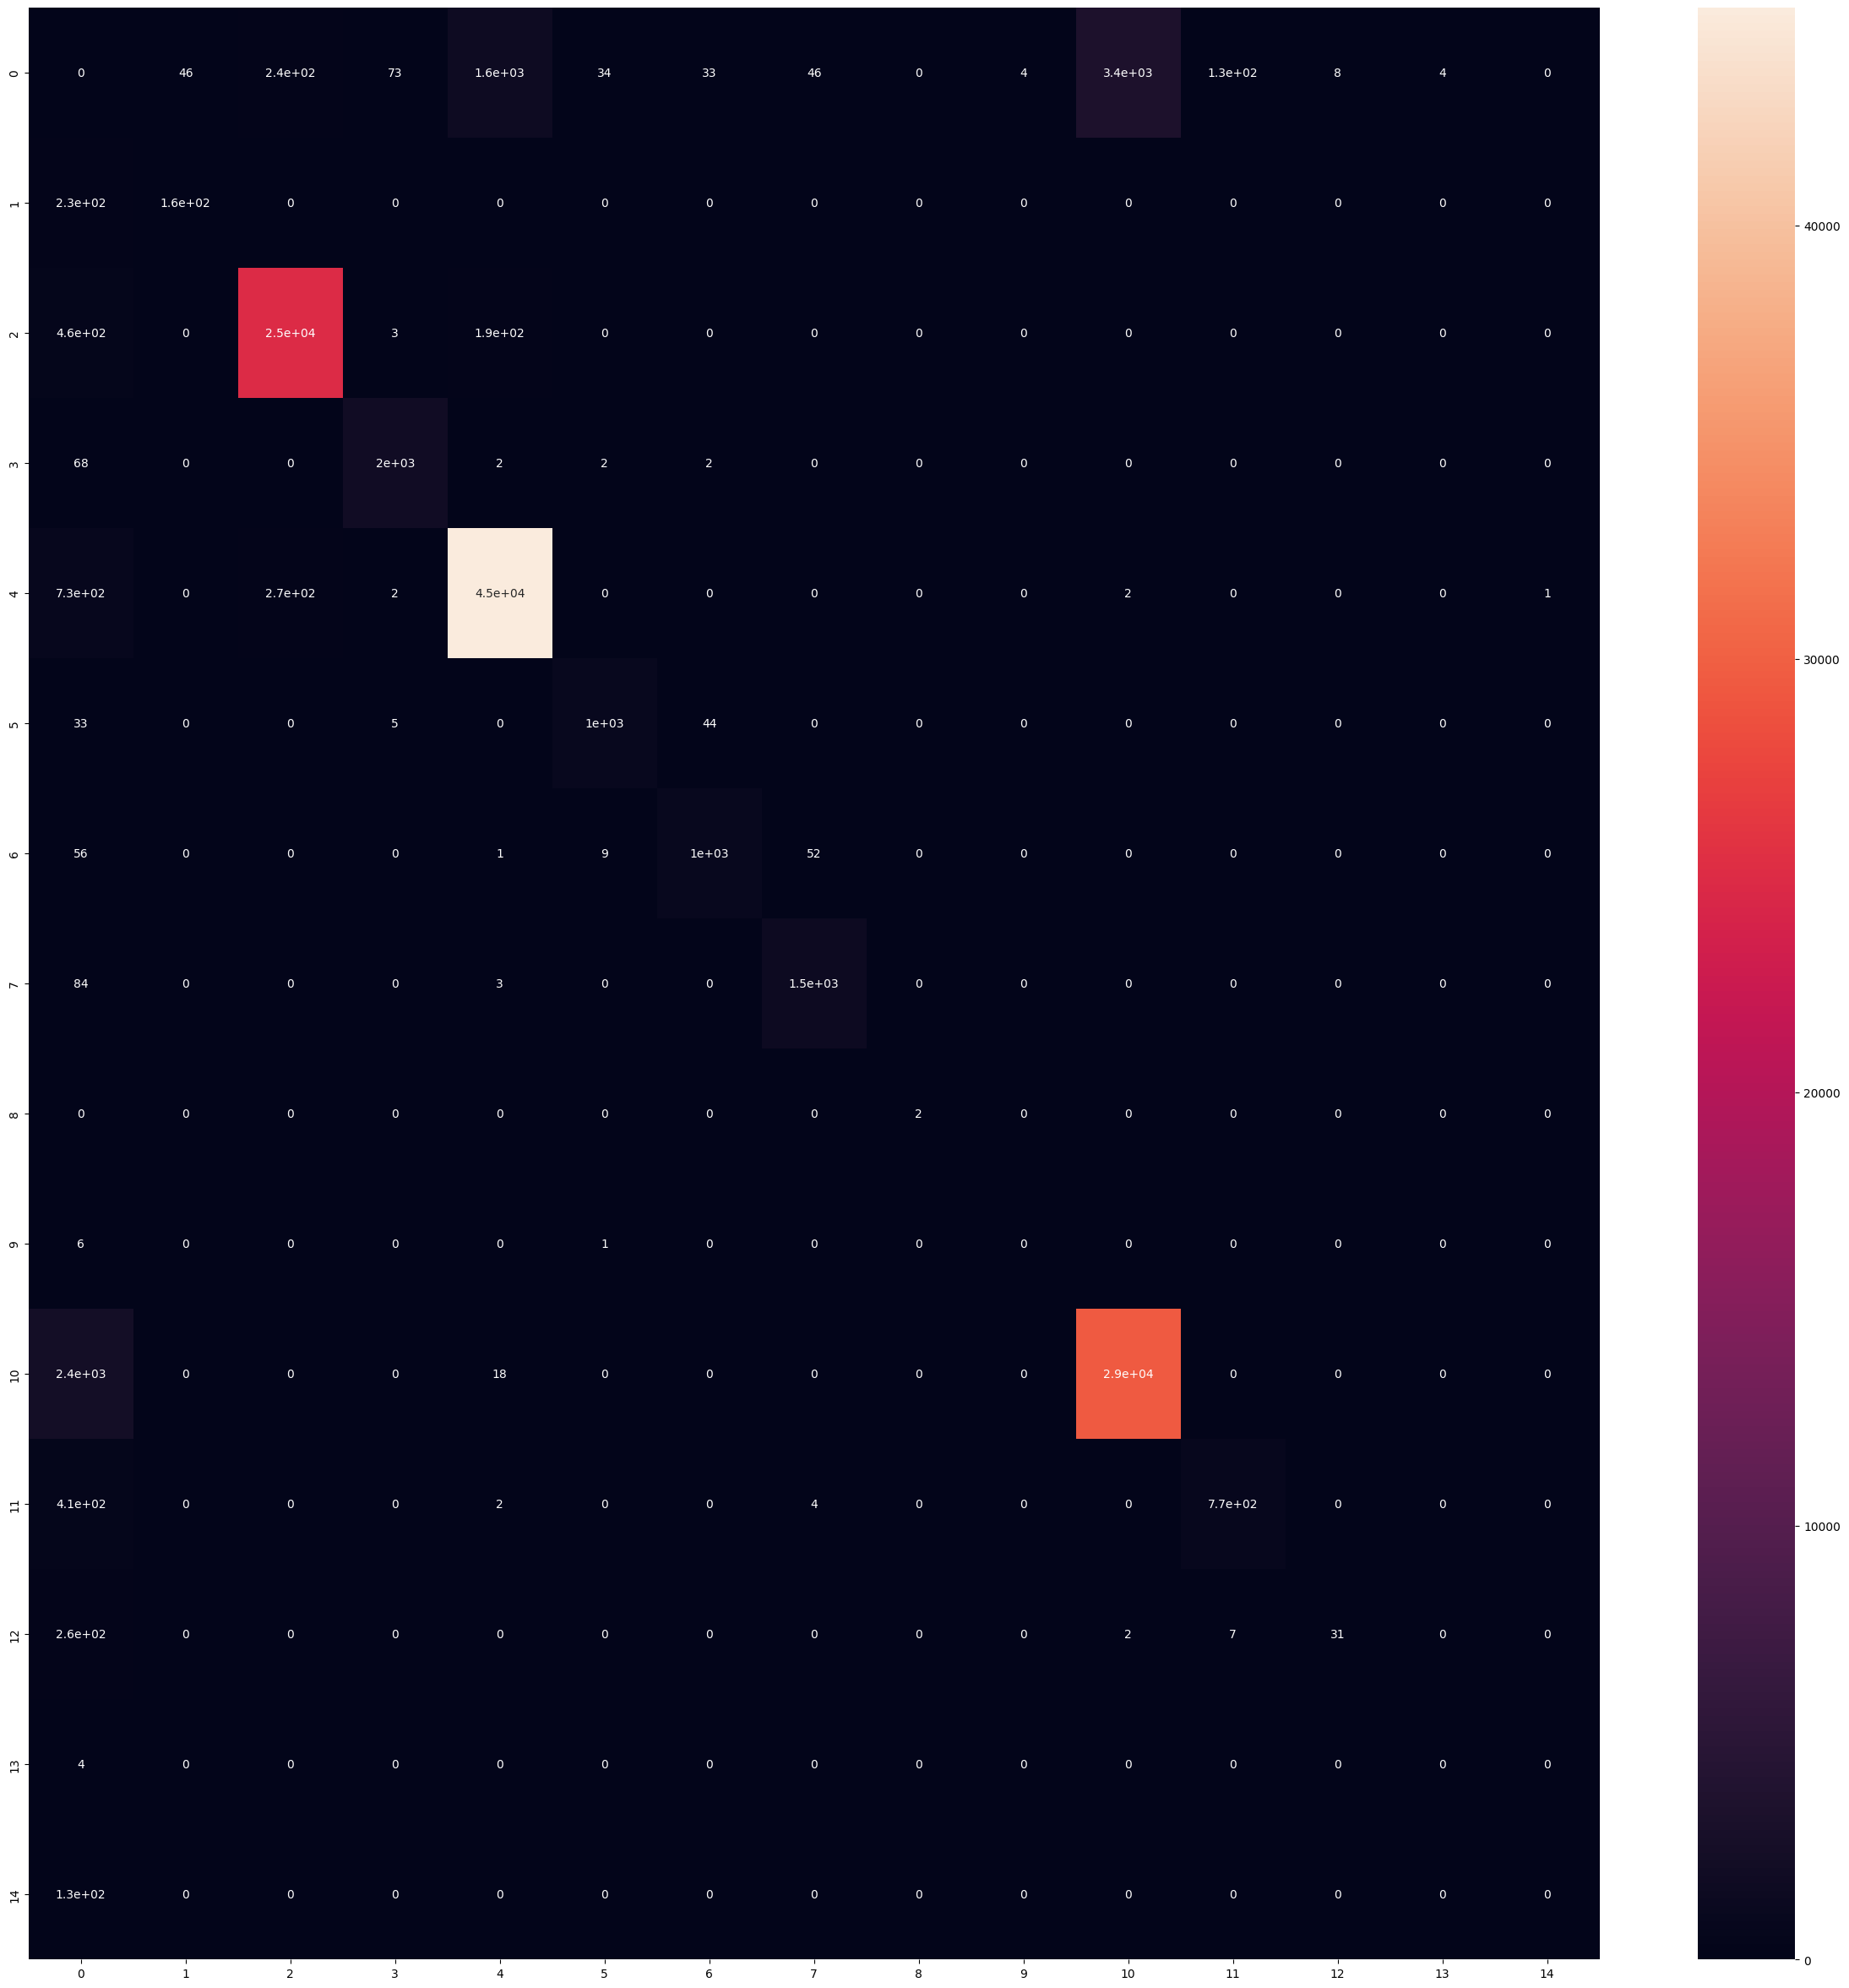

In [35]:
# cf_matrix_resnet_resnet[0][0] = 0

plt.figure(figsize=(15, 15))
sns.heatmap(cf_matrix_resnet_resnet, annot=True)
# cf_matrix_mlp_mlp.shape
# cf_matrix_resnet_resnet

<Axes: >

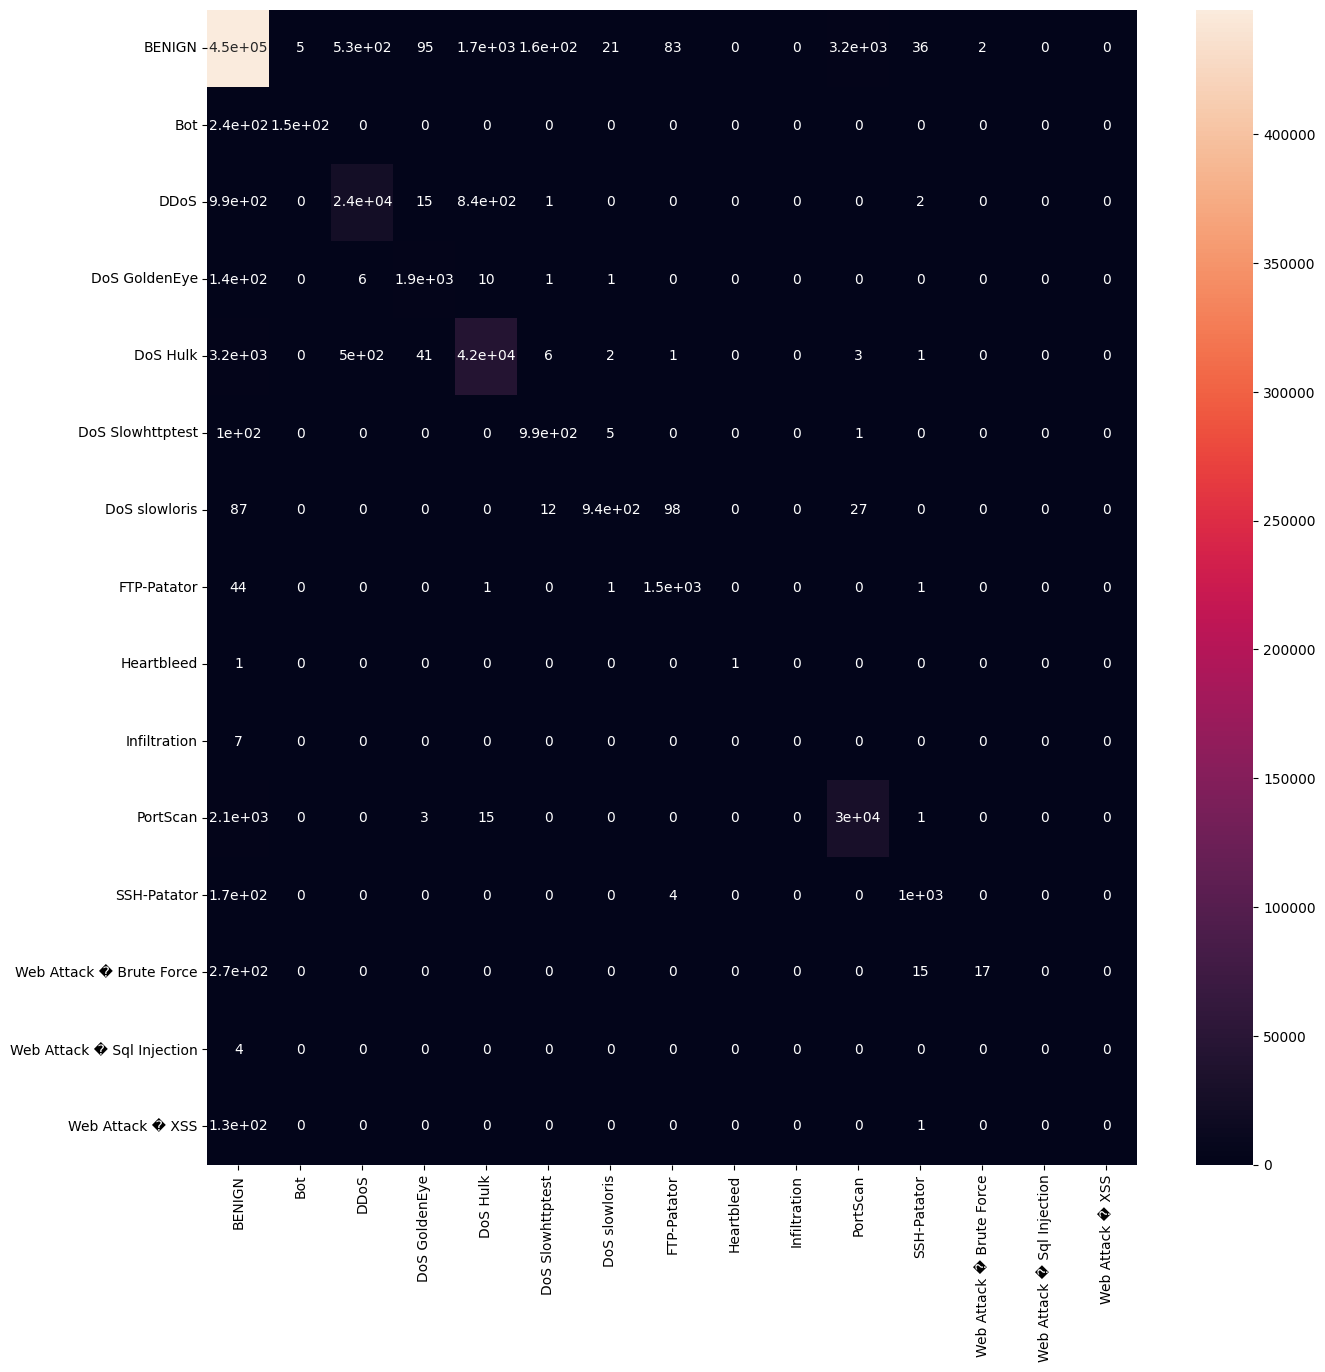

In [38]:
plt.figure(figsize=(15, 15))
sns.heatmap(cf_matrix_mlp_mlp, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)